## Importing Libraries

In [0]:
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import sys



C:\Users\raman\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Reading and preprocessing data

In [0]:
df=pd.read_csv(r'C:\Users\raman\Downloads\2901c100-b-Dataset\Dataset\train.csv')

In [0]:
df_test=pd.read_csv(r'C:\Users\raman\Downloads\2901c100-b-Dataset\Dataset\test.csv')

In [0]:
df.shape

(5959, 3)

In [0]:
df.columns

Index(['Review Text', 'Review Title', 'topic'], dtype='object')

In [0]:
df.isnull().sum(axis=0) #Checking Null values

Review Text     0
Review Title    0
topic           0
dtype: int64

In [0]:
print('Processing text dataset')

Processing text dataset


In [0]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)




## Initializaing parameters

In [0]:
EMBEDDING_FILE = r'C:\Users\raman\Downloads\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin'
TRAIN_DATA_FILE = r'C:\Users\raman\Downloads\2901c100-b-Dataset\Dataset\train.csv'
TEST_DATA_FILE = r'C:\Users\raman\Downloads\2901c100-b-Dataset\Dataset\test.csv'
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1

In [0]:
TRAIN_DATA_FILE

'C:\\Users\\raman\\Downloads\\2901c100-b-Dataset\\Dataset\\train.csv'

In [0]:
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [0]:
act = 'relu'
re_weight = True

In [0]:
STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

### Word2Vec

In [0]:
print('Indexing word vectors')

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Indexing word vectors
Found 3000000 word vectors of word2vec


In [0]:
texts_1 = [] 
texts_2 = []
labels = []

In [0]:
from sklearn import preprocessing

## Converting topics to labels and then to categorical variables

In [0]:
LE = preprocessing.LabelEncoder()
df['topic'] = LE.fit_transform(df['topic'])

In [0]:
k=LE.fit_transform(df1["topic"])

In [0]:
num_classes=21
import keras.utils
#Convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(df["topic"], num_classes)

In [0]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0.], dtype=float32)

In [0]:
df1=pd.read_csv(r'C:\Users\raman\Downloads\2901c100-b-Dataset\Dataset\train.csv')

### Converting to words

In [0]:
for i in range(df.shape[0]):
    texts_1.append(text_to_wordlist(df["Review Text"][i]))
    texts_2.append(text_to_wordlist(df["Review Title"][i]))
    labels.append(int(df["topic"][i]))
    
print('Found %s texts in train.csv' % len(texts_1))

Found 5959 texts in train.csv


In [0]:
test_texts_1 = []
test_texts_2 = []
for i in range(df_test.shape[0]):
    test_texts_1.append(text_to_wordlist(df_test["Review Text"][i]))
    test_texts_2.append(text_to_wordlist(df_test["Review Title"][i]))
print('Found %s texts in test.csv' % len(test_texts_1))

Found 2553 texts in test.csv


### Tokenizing

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_1 + texts_2 + test_texts_1 + test_texts_2)
sequences_1 = tokenizer.texts_to_sequences(texts_1)
sequences_2 = tokenizer.texts_to_sequences(texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 10312 unique tokens


### Padding to bring all sequences to equal length

In [0]:
data_1 = pad_sequences(sequences_1,maxlen=200)
data_2 = pad_sequences(sequences_2,maxlen=200)
labels = np.array(labels)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)



Shape of data tensor: (5959, 200)
Shape of label tensor: (5959,)


In [0]:
test_data_1 = pad_sequences(test_sequences_1,maxlen=200)
test_data_2 = pad_sequences(test_sequences_2,maxlen=200)

### Preparing Embedding matrix

In [0]:
print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))


Preparing embedding matrix
Null word embeddings: 1132


In [0]:
perm = np.random.permutation(len(data_1))
idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
labels_train = np.concatenate((Y_train[idx_train], Y_train[idx_train]))

data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
labels_val = np.concatenate((Y_train[idx_val], Y_train[idx_val]))

## Defining LSTM model

In [0]:
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=200,
        trainable=False)
lstm_layer = LSTM(2, dropout=0.2)

sequence_1_input = Input(shape=(200,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(200,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)

merged = Dense(512, activation=act)(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)

merged = Dense(256, activation=act)(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)

preds = Dense(21, activation='softmax')(merged)

In [0]:
sequence_2_input.shape

TensorShape([Dimension(None), Dimension(30)])

In [0]:
model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
#model.summary()
print(STAMP)

lstm_214_133_0.34_0.38


## Training model

In [0]:
early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

#hist = model.fit([data_1_train, data_2_train], Y_train,epochs=10, batch_size=500,validation_spilt=0.2)
hist = model.fit([data_1_train, data_2_train], labels_train, \
        validation_data=([data_1_val, data_2_val], labels_val), \
        epochs=10, batch_size=500,callbacks=[early_stopping, model_checkpoint])
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

Instructions for updating:
Use tf.cast instead.
Train on 10726 samples, validate on 1192 samples
Epoch 1/10
10726/10726 [==============================] - 57s 5ms/step - loss: 0.2033 - acc: 0.9507 - val_loss: 0.1824 - val_acc: 0.9524
Epoch 2/10
10726/10726 [==============================] - 42s 4ms/step - loss: 0.1791 - acc: 0.9518 - val_loss: 0.1692 - val_acc: 0.9523
Epoch 3/10
10726/10726 [==============================] - 48s 4ms/step - loss: 0.1683 - acc: 0.9519 - val_loss: 0.1596 - val_acc: 0.9541
Epoch 4/10
10726/10726 [==============================] - 49s 5ms/step - loss: 0.1609 - acc: 0.9521 - val_loss: 0.1549 - val_acc: 0.9536
Epoch 5/10
10726/10726 [==============================] - 46s 4ms/step - loss: 0.1561 - acc: 0.9526 - val_loss: 0.1492 - val_acc: 0.9548
Epoch 6/10
10726/10726 [==============================] - 42s 4ms/step - loss: 0.1539 - acc: 0.9528 - val_loss: 0.1476 - val_acc: 0.9547
Epoch 7/10
10726/10726 [==============================] - 44s 4ms/step - loss: 0.

## Plotting loss

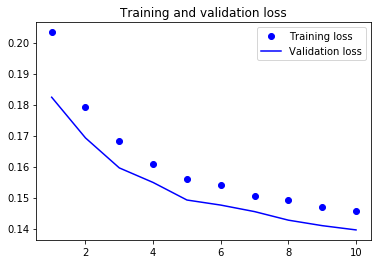

In [0]:
import matplotlib.pyplot as plt

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Making predictions

In [0]:
print('Start making the submission before fine-tuning')

preds = model.predict([test_data_1, test_data_2], verbose=1)

submission = pd.DataFrame(preds)


Start making the submission before fine-tuning
2553/2553 [==============================] - 7s 3ms/step


In [0]:
pred=submission.idxmax(axis=1)

In [0]:
true_lab=LE.inverse_transform(pred) ## Converting back to labels

In [0]:
true_lab

array(['Bad Taste/Flavor', 'Bad Taste/Flavor', 'Not Effective', ...,
       'Bad Taste/Flavor', 'Quality/Contaminated', 'Too big to swallow'],
      dtype=object)

In [0]:
TR=pd.DataFrame(true_lab)

In [0]:
TR.to_csv("Truelabels.csv") # Saving preictions